In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### **ARIMA**

In [2]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime
from funcs_indicator import *



def arima_close(target, use_rows=None):

  size = int(len(target) * 0.66)
  train, test = target[:size].values, target[size:]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 4))
      model_fit = model.fit()
      output = model_fit.forecast()
      # print(output)
      # break

      predictions.append(output[0])
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, indicator, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False, show_chart=False):

  
  high, low, close = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)
  indicator = indicator.values

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(close):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(close)):

    long_ep = predictions[i]
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    #         tick range 내에 ep 가 포함되어야함      #
    # if low[i] < long_ep:

    #       new constraint    #
    # if indicator[i - 1] < close[i - 1]:   # sar, ema1
    if indicator[i - 2] < 50 and indicator[i - 1] > 50:   # stoch_d
      pass
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)
      continue

    if low[i] < long_ep < high[i]:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = close[i] / long_ep - fee

        else:
          profit = close[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(close[i], predictions[i], long_ep)

      if show_chart:
        if i > 10:
          plt.plot(close[i + 1 - 10: i + 1], label='close')
          # plt.plot(predictions[i + 1 - 10: i + 1], label='ep')
          # plt.plot(high[i + 1 - 10: i + 1], label='high')
          # plt.plot(low[i + 1 - 10: i + 1], label='low')
          plt.plot(indicator[i + 1 - 10: i + 1], label='indicator')
          plt.legend()
          plt.show()

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / close[i] - fee
    #         else:
    #           profit = close[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / close[i] - fee
    #       else:
    #         profit = close[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(close[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(close)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(close)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-04-27 BTCUSDT.xlsx', '2021-04-27 ETHUSDT.xlsx', '2021-04-27 BCHUSDT.xlsx', '2021-04-27 XRPUSDT.xlsx', '2021-04-27 EOSUSDT.xlsx', '2021-04-27 LTCUSDT.xlsx', '2021-04-27 ETCUSDT.xlsx', '2021-04-27 LINKUSDT.xlsx', '2021-04-27 XLMUSDT.xlsx', '2021-04-27 ADAUSDT.xlsx', '2021-04-27 XMRUSDT.xlsx', '2021-04-27 SXPUSDT.xlsx', '2021-04-27 KAVAUSDT.xlsx', '2021-04-27 BANDUSDT.xlsx', '2021-04-27 DASHUSDT.xlsx', '2021-04-27 ZECUSDT.xlsx', '2021-04-27 XTZUSDT.xlsx', '2021-04-27 BNBUSDT.xlsx', '2021-04-27 ATOMUSDT.xlsx', '2021-04-27 ONTUSDT.xlsx', '2021-04-27 IOTAUSDT.xlsx', '2021-04-27 BATUSDT.xlsx', '2021-04-27 NEOUSDT.xlsx', '2021-04-27 QTUMUSDT.xlsx', '2021-04-27 WAVESUSDT.xlsx', '2021-04-27 MKRUSDT.xlsx', '2021-04-27 SNXUSDT.xlsx', '2021-04-27 DOTUSDT.xlsx', '2021-04-27 THETAUSDT.xlsx', '2021-04-27 ALGOUSDT.xlsx', '2021-04-27 KNCUSDT.xlsx', '2021-04-27 ZRXUSDT.xlsx', '2021-04-27 COMPUSDT.xlsx', '2021-04-27 OMGUSDT.xlsx']


### Load candle

In [52]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split
from datetime import datetime

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from funcs_indicator import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


os.chdir(current_path)

start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

long_index = 0
leverage = 5
prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

result_df = pd.DataFrame(index=candis)
pairs_pr, pairs_wr = [], []

for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue


  # if '02-11' not in candis[i]:  # <-- 04-08 includes all timestamp range
  #   continue  

  if 'sxp'.upper() not in candis[i]:
    continue



  for key in keys:  

    # print(profit_result_dict[key]['leverage_ap_list'])

    # for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      # ohlcv = load_dict[key]['ohlcv']

    # if 'eth'.upper() not in key:
    #   continue
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))


start_stamp : 0
len(ohlcv) : 13452


In [53]:
candle_path = '/candlestick_patterns/'
os.chdir(current_path + candle_path)

from candlestick import candlestick

In [54]:
new_ohlcv = ohlcv

In [55]:
new_ohlcv = candlestick.inverted_hammer(ohlcv, target='inverted_hammer')
new_ohlcv = candlestick.hanging_man(new_ohlcv, target='hanging_man')
new_ohlcv = candlestick.bearish_harami(new_ohlcv, target='bearish_harami')
new_ohlcv = candlestick.bullish_harami(new_ohlcv, target='bullish_harami')
new_ohlcv = candlestick.gravestone_doji(new_ohlcv, target='gravestone_doji')
new_ohlcv = candlestick.doji(new_ohlcv, target='doji')
new_ohlcv = candlestick.dark_cloud_cover(new_ohlcv, target='dark_cloud_cover')
new_ohlcv = candlestick.doji_star(new_ohlcv, target='doji_star')
new_ohlcv = candlestick.dragonfly_doji(new_ohlcv, target='dragonfly_doji')
new_ohlcv = candlestick.bearish_engulfing(new_ohlcv, target='bearish_engulfing')
new_ohlcv = candlestick.bullish_engulfing(new_ohlcv, target='bullish_engulfing')
new_ohlcv = candlestick.hammer(new_ohlcv, target='hammer')
new_ohlcv = candlestick.morning_star(new_ohlcv, target='morning_star')
new_ohlcv = candlestick.morning_star_doji(new_ohlcv, target='morning_star_doji')
new_ohlcv = candlestick.piercing_pattern(new_ohlcv, target='piercing_pattern')
new_ohlcv = candlestick.rain_drop(new_ohlcv, target='rain_drop')
new_ohlcv = candlestick.rain_drop_doji(new_ohlcv, target='rain_drop_doji')
new_ohlcv = candlestick.star(new_ohlcv, target='star')
new_ohlcv = candlestick.shooting_star(new_ohlcv, target='shooting_star')
print(new_ohlcv.head())

/content/drive/My Drive/Colab Notebooks/300/candlestick_patterns/candlestick/patterns/gravestone_doji.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return (abs(close - open) / (high - low) < 0.1 and
/content/drive/My Drive/Colab Notebooks/300/candlestick_patterns/candlestick/patterns/doji.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return abs(close - open) / (high - low) < 0.1 and \
/content/drive/My Drive/Colab Notebooks/300/candlestick_patterns/candlestick/patterns/dragonfly_doji.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return abs(close - open) / (high - low) < 0.1 and \


                           open    high     low   close     volume  inverted_hammer hanging_man bearish_harami bullish_harami  gravestone_doji   doji dark_cloud_cover doji_star  dragonfly_doji bearish_engulfing bullish_engulfing  hammer morning_star morning_star_doji piercing_pattern rain_drop rain_drop_doji   star shooting_star
2020-07-21 18:29:59.999  1.4800  1.6583  1.4800  1.6128  1280481.5            False        None           None           None            False  False             None      None           False              None              None   False         None              None             None      None           None   None          None
2020-07-21 18:59:59.999  1.6134  1.6233  1.5698  1.5900   591016.9            False        None          False          False            False  False            False     False           False             False             False   False         None              None            False     False          False  False         False
2020-07

In [8]:
pattern_columns = list(new_ohlcv.columns[5:])
# print((pattern_columns))

bull_c, bear_c = [], []
for c in pattern_columns:
  
  if 'bear' in c:
    bear_c.append(c)

  elif 'hang' in c:
    bear_c.append(c)

  elif 'grave' in c:
    bear_c.append(c)

  elif 'dark' in c:
    bear_c.append(c)

  elif 'dragon' in c:
    bear_c.append(c)

  elif 'shooting' in c:
    bear_c.append(c)

  elif 'star' == c:
    bear_c.append(c)


  else:
    bull_c.append(c)

print((bull_c))
print((bear_c))


['inverted_hammer', 'bullish_harami', 'doji', 'doji_star', 'bullish_engulfing', 'hammer', 'morning_star', 'morning_star_doji', 'piercing_pattern', 'rain_drop', 'rain_drop_doji']
['hanging_man', 'bearish_harami', 'gravestone_doji', 'dark_cloud_cover', 'dragonfly_doji', 'bearish_engulfing', 'star', 'shooting_star']


### plot pattern

In [ ]:
!pip install mpl_finance

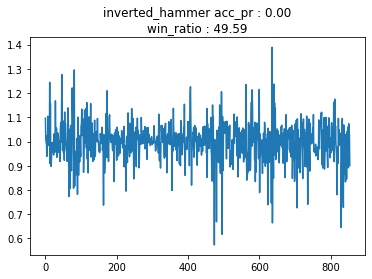

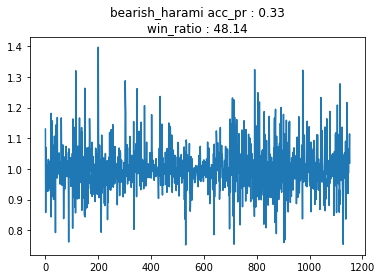

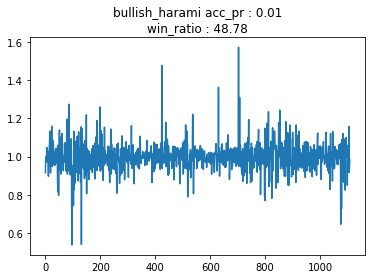

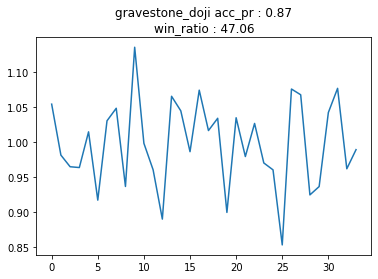

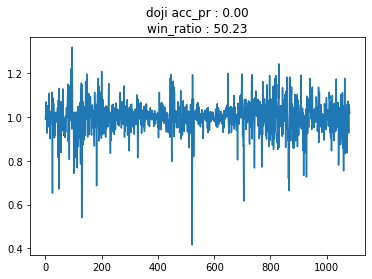

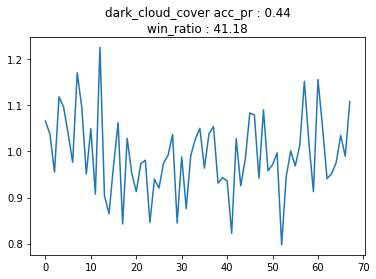

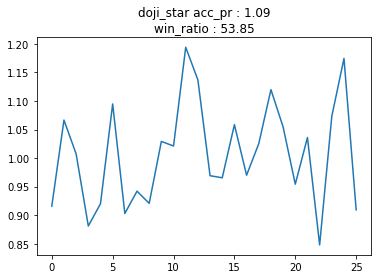

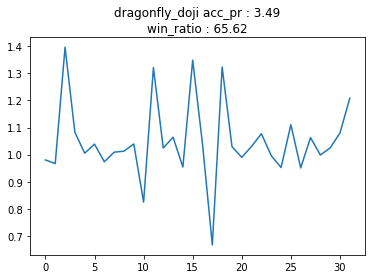

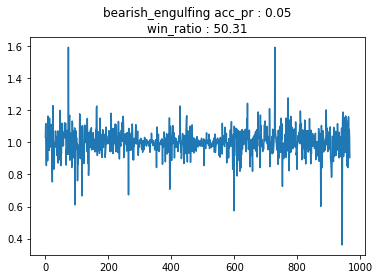

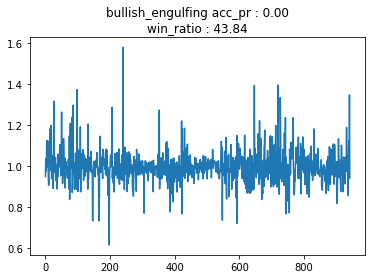

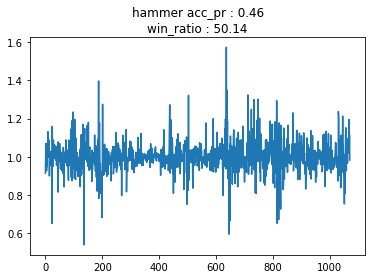

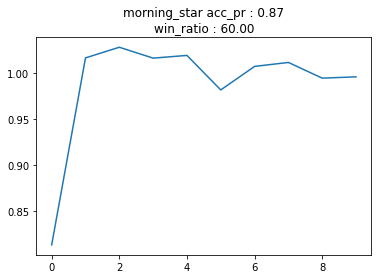

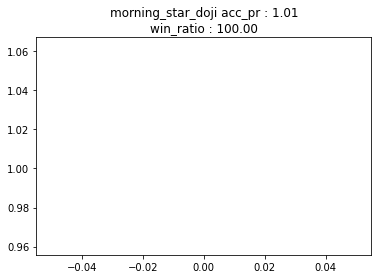

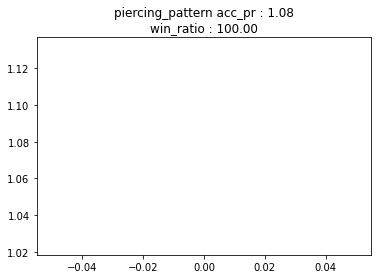

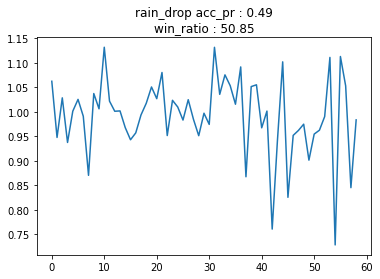

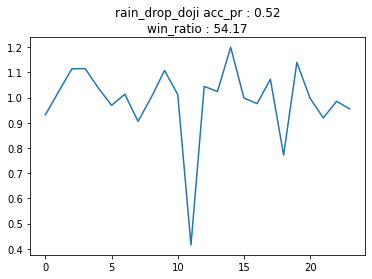

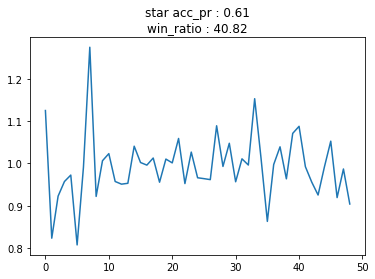

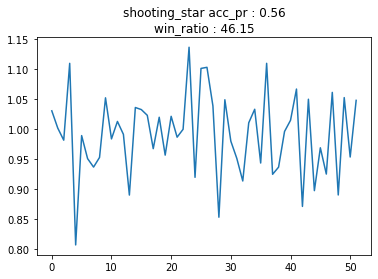

In [58]:
import mpl_finance as mf

target_pt = pattern_columns[0]
plot_size = 5

for target_pt in pattern_columns:

  pt_pr = []
  for i in range(plot_size, len(new_ohlcv)):

    if new_ohlcv[target_pt].iloc[i]:
      
      # fig = plt.figure(figsize=(4, 4))
      # ax = fig.add_subplot(111)

      # ohlc = new_ohlcv.iloc[i + 1 - plot_size : i + 1, :4].values

      # # ohlc = df2.iloc[:, :4]
      # index = np.arange(len(ohlc))
      # ohlc = np.hstack((np.reshape(index, (-1, 1)), ohlc))
      # mf.candlestick_ohlc(ax, ohlc, width=0.5, colorup='r', colordown='b')

      # plt.title(target_pt)
      # plt.show()

      #            calc pr           #
      if i < len(new_ohlcv) - 1:
        close = new_ohlcv.iloc[:, [3]].values
        exit = close[i + 1]
        entry = close[i]

        pr = (exit / entry - 0.0006 - 1) * 5 + 1
        # pr = (entry / exit - 0.0006 - 1) * 5 + 1
        pt_pr.append(pr)

  if len(pt_pr) > 0:
    plt.plot(pt_pr)
    wr = np.sum(np.array(pt_pr) > 1) / len(pt_pr) * 100
    plt.title("%s acc_pr : %.2f\nwin_ratio : %.2f" % (target_pt, np.cumprod(pt_pr)[-1], wr))
    plt.show()

      # break

In [38]:
def get_prediction_score(data, candlestick_pattern: str):
    '''
    takes in a dataframe and the name of a candlestick pattern and calculates the fraction of times the candlestick patter
    managed to predict the market correctly
    '''
    initial_prices = data['close'][data[candlestick_pattern]==1]
    next_price_point = data['close'][data[candlestick_pattern].shift(1)==1]

    price_increased = next_price_point.reset_index(drop=True) > initial_prices.reset_index(drop=True)
    price_dropped = next_price_point.reset_index(drop=True) < initial_prices.reset_index(drop=True)
    if candlestick_pattern in bull_c:
        # prediction_score = price_increased.sum()/len(price_increased)
        # return prediction_score

        # pr = (next_price_point / initial_prices).values
        pr = (initial_prices / next_price_point).values

        pr = pr.reshape(-1, 1)
        # print(pr.shape)

        lv_pr = (pr - 0.0006 - 1) * 5 + 1
        lv_pr[np.isnan(lv_pr)] = 1

        # print(np.cumprod(lv_pr)[-1])

        return lv_pr


    # elif used rather than else to prevent typos to misclassify bullish and bearish signals
    elif candlestick_pattern in bear_c:
        # prediction_score = price_dropped.sum()/len(price_dropped)
        # return prediction_score

        pr = (next_price_point / initial_prices).values
        # pr = (initial_prices / next_price_point).values

        pr = pr.reshape(-1, 1)

        lv_pr = (pr - 0.0006 - 1) * 5 + 1
        lv_pr[np.isnan(lv_pr)] = 1

        return lv_pr

    else:
        print(f'Sorry, {candlestick_pattern} was not found in our list of modeled candlestick pattern ')
        

In [39]:
scores = pd.Series()
candlesticks = pattern_columns
for pattern in candlesticks:
  try:
    scores[pattern] = get_prediction_score(new_ohlcv, pattern)
  except:
    scores[pattern] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
print()
for i in range(len(scores[candlesticks[0]])):
  if not np.isnan(scores[candlesticks[0]][i]):
    print(scores[candlesticks[0]][i])

In [23]:
ax = scores.plot.bar(color='green')
ax.set_title('Prediction Score of Candlestick Patterns')
# ax.set_ylim(0,)
ax.axhline(1)
ax.grid()

TypeError: ignored

In [ ]:
pr_list = pd.Series()
candlesticks = pattern_columns
for pattern in candlesticks:
  try:
    pr_list[pattern] = get_prediction_score(new_ohlcv, pattern)
  except:
    pr_list[pattern] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
# print(pr_list.index)
for c in list(pr_list.index):

  plt.plot(pr_list[c])
  plt.title(c)
  plt.show()

Text(0.5, 1.0, 'Frequency of Patterns in Apple Stock')

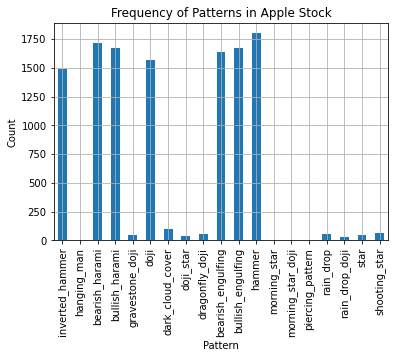

In [ ]:
candlesticks_count = new_ohlcv.drop(['open','close','high','low','volume'],axis=1).sum()
# print(candlesticks_count)
ax = candlesticks_count.plot.bar()
ax.grid()
ax.set_xlabel('Pattern')
ax.set_ylabel('Count')
ax.set_title('Frequency of Patterns in Apple Stock')

### Check shuffled index

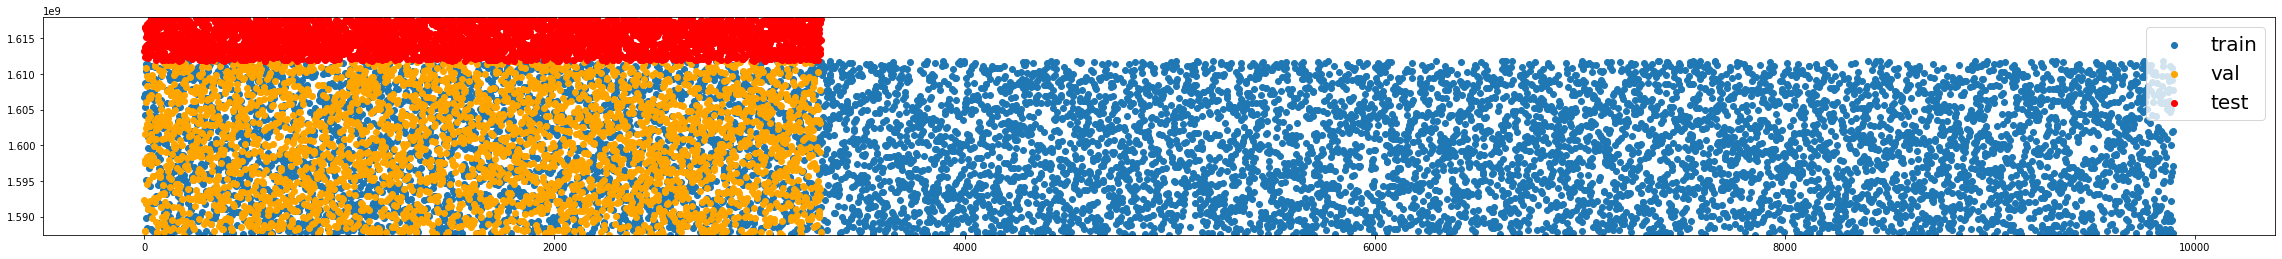

In [ ]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

### Load Data

In [ ]:
period = 45

x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_neo_timesplit.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_neo_timesplit.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

_, row, col = x_train.shape



x series loaded !
y series loaded !


In [ ]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


### **Data Split**

### **Training**

In [ ]:
org_x_test = x_test
org_y_test = y_test
org_pr_test = pr_test

In [ ]:
x_test = org_x_test
y_test = org_y_test
pr_test = org_pr_test

In [ ]:
concat_x = np.vstack((org_x_test, new_input_x))
concat_y = np.vstack((org_y_test, np.where(new_input_pr > 1, 1, 0)))
concat_pr = np.vstack((org_pr_test, new_input_pr))

In [ ]:
x_test = new_input_x
y_test = np.where(new_input_pr > 1, 1, 0)
pr_test = new_input_pr

In [ ]:
# print(pred_pr_list)
for pr in pred_pr_list:
  if pr != 1:
    print(pr)

In [ ]:
plt.figure(figsize=(50, 5))
plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test):len(org_pr_test) + 10])
# plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test) - 10:len(org_pr_test) + 10])
plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
# plt.axvline(len(org_pr_test), linestyle='--', color='r')
plt.show()

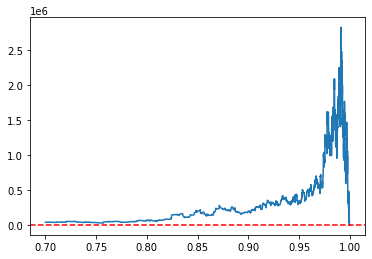

In [ ]:
# plt.show()
# plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

